**This script contains the figure generating functions for Fig 3.A**

In [1]:
############### LOADING DATA ###############

%run '/home/christianl/Zhang-Lab/Zhang Lab Code/Boilerplate_datahandling/Remote boilerplate/model_load.py'

Loading pre-computed predictions...
✓ Loaded predictions for 3 models
  Training samples: 12748, Genes: 16100
  Test samples: 3187, Genes: 16100
  Val samples: 262, Genes: 16100

✓ All functions loaded. Ready for analysis!


In [3]:
############### ALTERNATIVE METHOD (CV-STRATIFIED) WITH RMSE/MAE ###############

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

MODEL_COLORS = {
    'MLR': '#2ca02c', 
    'XGBRFRegressor': '#ff7f0e', 
    'RNN': '#1f77b4'
}

def set_publication_style():
    """Apply consistent publication-quality styling."""
    import seaborn as sns
    sns.set_style("whitegrid")
    plt.rcParams.update({
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'font.size': 11,
        'axes.labelsize': 12,
        'axes.titlesize': 13,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'axes.linewidth': 1.2,
        'xtick.major.width': 1.2,
        'ytick.major.width': 1.2,
        'xtick.major.size': 5,
        'ytick.major.size': 5,
    })

def figure_2_stratified_cv_validation(y_true, predictions_dict, 
                          output_path='/home/christianl/Zhang-Lab/Zhang Lab Data/Saved figures/Production_model_figures(x_validation)'):
    """
    Diagnostic suite: Stratifies by Coefficient of Variation (CV).
    Shows RMSE and MAE metrics for each stratum and model.
    
    Parameters
    ----------
    y_true : pd.DataFrame
        True gene expression values (samples × genes)
    predictions_dict : dict
        Dictionary mapping model names to prediction arrays/DataFrames
    output_path : str
        Path to save the output figure
        
    Returns
    -------
    fig, axes : matplotlib figure and axes objects
    """
    set_publication_style()
    
    # 1. Setup Data & Strata using CV (Variance / Mean)
    gene_means = y_true.mean(axis=0)
    gene_stds = y_true.std(axis=0)
    # Calculate CV; handle potential zeros by replacing with NaN then ignoring
    gene_cv = (gene_stds / gene_means).replace([np.inf, -np.inf], np.nan)
    gene_names = y_true.columns
    
    # Determine Quantiles for balanced n (33rd and 67th percentiles)
    q1, q2 = np.nanpercentile(gene_cv, [33.33, 66.67])
        
    # Define Variance Strata based on CV percentiles
    strata_masks = {
        f'Low Variance (CV < {q1:.2f})': gene_cv <= q1,
        f'Medium Variance ({q1:.2f}-{q2:.2f})': (gene_cv > q1) & (gene_cv <= q2),
        f'High Variance (CV > {q2:.2f})': gene_cv > q2
    }
    
    # Dynamically get model names from dict
    model_names = list(predictions_dict.keys())
    
    # 3x3 Grid: Rows = Strata, Cols = Models
    fig, axes = plt.subplots(len(strata_masks), len(model_names), 
                             figsize=(18, 15), sharex='col', sharey='row')
    
    for row_idx, (stratum_name, mask) in enumerate(strata_masks.items()):
        # Ensure we drop NaNs if CV couldn't be calculated for specific genes
        mask = mask.fillna(False)
        stratum_genes = gene_names[mask]
        y_true_stratum = y_true.loc[:, mask].values 
        
        for col_idx, model_name in enumerate(model_names):
            ax = axes[row_idx, col_idx]
            y_pred_raw = predictions_dict[model_name]
            y_pred_stratum = y_pred_raw.loc[:, mask].values if hasattr(y_pred_raw, 'loc') else y_pred_raw[:, mask]
            
            # --- COMPUTE METRICS ---
            residuals = (y_true_stratum - y_pred_stratum)
            
            # Flatten for overall stratum metrics
            y_true_flat = y_true_stratum.ravel()
            y_pred_flat = y_pred_stratum.ravel()
            res_flat = residuals.ravel()
            
            # Calculate RMSE and MAE
            rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
            mae = mean_absolute_error(y_true_flat, y_pred_flat)
            
            # Additional useful metrics
            pearson_r, _ = pearsonr(y_true_flat, y_pred_flat)
            residual_std = np.std(res_flat)
            mean_bias = np.mean(res_flat)
            
            # Plotting - subsample if too many points for visualization
            if len(res_flat) > 50000:
                idx = np.random.choice(len(res_flat), 50000, replace=False)
                ax.scatter(y_pred_flat[idx], res_flat[idx], alpha=0.5, s=5, 
                           color=MODEL_COLORS.get(model_name, '#1f77b4'), edgecolors='none')
            else:
                ax.scatter(y_pred_flat, res_flat, alpha=0.5, s=5, 
                           color=MODEL_COLORS.get(model_name, '#1f77b4'), edgecolors='none')

            # Zero-baseline
            ax.axhline(0, color='k', linestyle='--', lw=1, alpha=0.5)
            
            # --- METRICS BOX ---
            textstr = (f"RMSE = {rmse:.4f}\n"
                      f"MAE = {mae:.4f}\n"
                      f"----------\n"
                      f"Pearson's R = {pearson_r:.4f}\n"
                      f"Mean Bias = {mean_bias:.4f}\n"
                      f"Residual SD = {residual_std:.4f}\n"
                      f"----------\n"
                      f"N genes = {len(stratum_genes):,}")
            
            ax.text(0.95, 0.95, textstr, transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', horizontalalignment='right', 
                    fontfamily='monospace', fontweight='normal',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8, edgecolor='none'))

            # --- LABELS & TITLES ---
            if row_idx == 0:
                ax.set_title(model_name, fontsize=13, fontweight='bold')
            
            if col_idx == 0:
                ax.set_ylabel(f"{stratum_name}\nResiduals (Log10)", fontsize=12, fontweight='bold')
            else:
                ax.set_ylabel('') 
                
            if row_idx == 2:
                ax.set_xlabel('Predicted Expression (Log10)', fontsize=12, fontweight='bold')
            
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-4, 4) 
            ax.set_xlim(0, 6)  

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Figure 2 (CV-Stratified with RMSE/MAE) saved to {output_path}")
    plt.show()
    
    return fig, axes

Figure 2 (CV-Stratified with RMSE/MAE) saved to figure_2_diagnostics_with_CR_validation.png


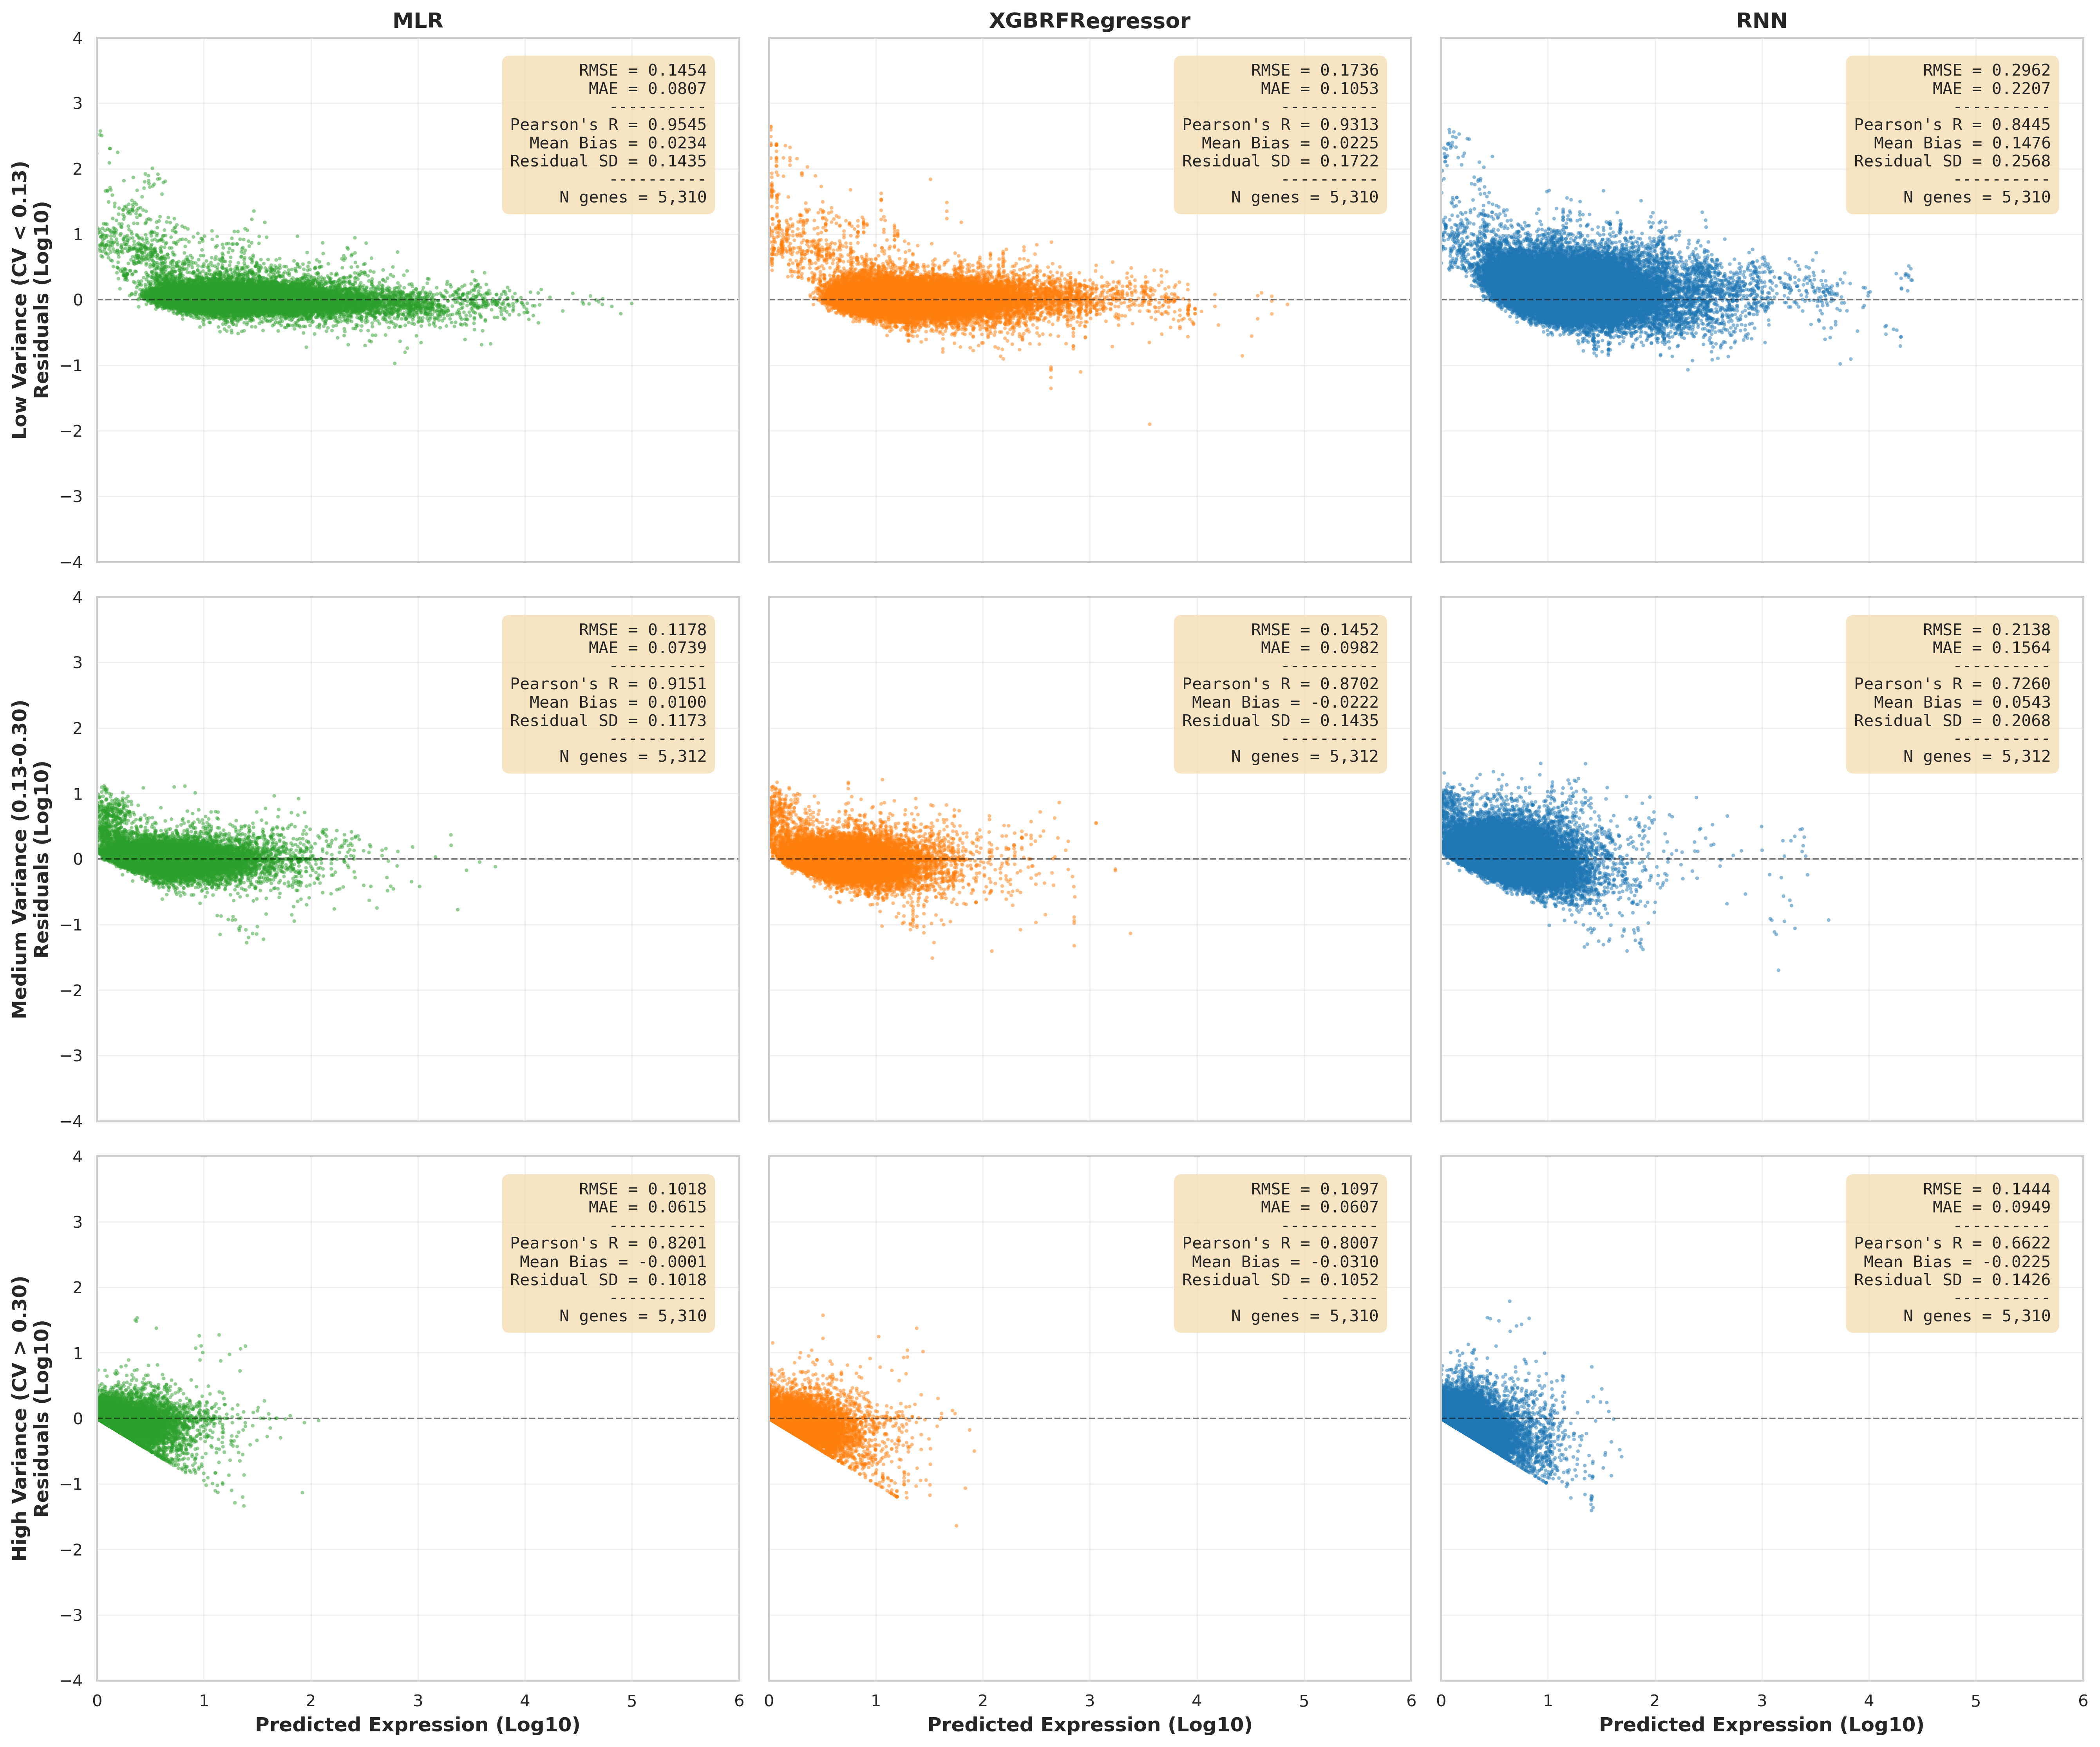

(<Figure size 5400x4500 with 9 Axes>,
 array([[<Axes: title={'center': 'MLR'}, ylabel='Low Variance (CV < 0.13)\nResiduals (Log10)'>,
         <Axes: title={'center': 'XGBRFRegressor'}>,
         <Axes: title={'center': 'RNN'}>],
        [<Axes: ylabel='Medium Variance (0.13-0.30)\nResiduals (Log10)'>,
         <Axes: >, <Axes: >],
        [<Axes: xlabel='Predicted Expression (Log10)', ylabel='High Variance (CV > 0.30)\nResiduals (Log10)'>,
         <Axes: xlabel='Predicted Expression (Log10)'>,
         <Axes: xlabel='Predicted Expression (Log10)'>]], dtype=object))

In [4]:
############### PLOTTING STEP (CV-STRATIFIED) ###############

figure_2_stratified_cv_validation(y_validation, predictions_validation, 'figure_2_diagnostics_with_CR_validation.png')